# **Downloading the dataset from Kaggle**

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d ritupande/fire-detection-from-cctv

 96% 312M/325M [00:02<00:00, 173MB/s]
100% 325M/325M [00:02<00:00, 144MB/s]


# **Importing necessary libraries and packages**

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf

# **Preprocessing the data**

In [4]:
!unzip '/content/fire-detection-from-cctv.zip'

Archive:  /content/fire-detection-from-cctv.zip
  inflating: data/data/img_data/test/default/img_102.jpg  
  inflating: data/data/img_data/test/default/img_112.jpg  
  inflating: data/data/img_data/test/default/img_113.jpg  
  inflating: data/data/img_data/test/default/img_114.jpg  
  inflating: data/data/img_data/test/default/img_132.jpg  
  inflating: data/data/img_data/test/default/img_133.jpg  
  inflating: data/data/img_data/test/default/img_137.jpg  
  inflating: data/data/img_data/test/default/img_138.jpg  
  inflating: data/data/img_data/test/default/img_200.jpg  
  inflating: data/data/img_data/test/default/img_201.jpg  
  inflating: data/data/img_data/test/default/img_202.jpg  
  inflating: data/data/img_data/test/default/img_203.jpg  
  inflating: data/data/img_data/test/default/img_204.jpg  
  inflating: data/data/img_data/test/default/img_205.jpg  
  inflating: data/data/img_data/test/default/img_206.jpg  
  inflating: data/data/img_data/test/default/img_207.jpg  
  inflat

In [5]:
# There is an extra folder inside the data directory with same data,hence removing it
!rm -r '/content/data/data'

In [6]:
dataset_path = '/content/data/img_data'
train_data_path = os.path.join(dataset_path, 'train')
validation_data_path = os.path.join(dataset_path, 'test')

# **Function to Count data in each Classes**

In [7]:
def count(path):

    # Initializing a dictionary to store class counts
    class_counts = {}

    for root, dirs, files in os.walk(path):
        for dir_name in dirs:
            full_path = os.path.join(root, dir_name)

            # Counting the number of files in each class
            class_cnt = len(os.listdir(full_path))
            class_counts[dir_name] = class_cnt

    return class_counts

In [8]:
print('training_data_count : ',count(train_data_path))
print('validation_data_count : ',count(validation_data_path))

training_data_count :  {'default': 161, 'fire': 274, 'smoke': 258}
validation_data_count :  {'default': 84, 'fire': 57, 'smoke': 30}


# **Function to create Data generators**

In [9]:
def preprocess_input_custom(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalizing pixel values to the range [0, 1]
    return image


def generate(model_name):

    #seperate pre-processing for seperate models
    if  model_name  == 'custom':
       preprocess_input = preprocess_input_custom
    elif model_name == 'vgg16':
        preprocess_input = preprocess_input_vgg16
    elif model_name == 'resnet50':
        preprocess_input = preprocess_input_resnet50


    #data augmentation
    data_generator_with_aug = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        zoom_range = [0.9, 1.5],
        horizontal_flip = True,
        vertical_flip = True,
        brightness_range = [0.3, 1.7],
        shear_range = 0.4,
        fill_mode = 'reflect'
        )

    train_data_generator = data_generator_with_aug.flow_from_directory(
        train_data_path,
        target_size = (224,224),
        batch_size = 32,
        color_mode = 'rgb',
        class_mode = 'categorical',
        shuffle=True,
        )

    validation_data_generator = data_generator_with_aug.flow_from_directory(
        validation_data_path,
        target_size = (224,224),
        batch_size = 32,
        color_mode = 'rgb',
        class_mode = 'categorical',
        shuffle=True
        )

    return train_data_generator, validation_data_generator

# **Function to calculate class weights**

In [10]:
train_data_generator, validation_data_generator = generate('custom')

def weight():

    class_labels = list(train_data_generator.class_indices.keys())

    unique_labels = []
    _ = [unique_labels.append(i) for i in train_data_generator.classes if i not in unique_labels]
    true_labels = train_data_generator.classes

    # Calculating the class weights
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=true_labels)

    # Creating a dictionary for mapping class labels to their respective weights
    class_weights_dict = dict(zip(unique_labels, class_weights))

    return class_weights_dict, unique_labels, true_labels, class_labels

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


**understand values in each variables**

In [11]:
class_weights_dict, unique_labels, true_labels, class_labels = weight()
print('training_data_count : ',   count(train_data_path), '\n' , '-'*80)
print('class_weights       : ',   class_weights_dict, '\n' , '-'*80)
print('class_labels        :',    class_labels , '\n','-'*80)
print('unique_labels       : ',   unique_labels, '\n' , '-'*80)
print('true labels         :\n ', true_labels, '\n' , '-'*80)

training_data_count :  {'default': 161, 'fire': 274, 'smoke': 258} 
 --------------------------------------------------------------------------------
class_weights       :  {0: 1.434782608695652, 1: 0.843065693430657, 2: 0.8953488372093024} 
 --------------------------------------------------------------------------------
class_labels        : ['default', 'fire', 'smoke'] 
 --------------------------------------------------------------------------------
unique_labels       :  [0, 1, 2] 
 --------------------------------------------------------------------------------
true labels         :
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 

# **Function to create model**

In [27]:
def create_model(model_name):

    # Loading data generators for each model
    train_data_generator, validation_data_generator = generate(model_name)

    # loading weight function to get weights of each class
    class_weights_dict, unique_labels, true_labels, class_labels = weight()

    if model_name == 'custom':

        # Defining model checkpoint callback for cutom model
        checkpoint = ModelCheckpoint("/content/model/custom.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

        model = Sequential([
            layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=[224, 224, 3]),
            layers.MaxPool2D(2, 2),
            layers.Dropout(0.5),

            layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D(2, 2),
            layers.Dropout(0.6),

            layers.GlobalAveragePooling2D(),

            layers.Dense(16, activation='relu'),
            layers.Dropout(0.7),

            layers.Dense(3, activation='softmax')
        ])

    elif model_name == 'vgg16':

        # Define model checkpoint callback for vggg16
        checkpoint = ModelCheckpoint("/content/model/vgg16.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

        vgg16_cnn = VGG16(weights='imagenet', include_top=False)

        for layer in vgg16_cnn.layers:
            layer.trainable = False

        x = GlobalAveragePooling2D()(vgg16_cnn.output)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)

        predictions = Dense(3, activation='softmax')(x)
        model = Model(inputs=vgg16_cnn.input, outputs=predictions)

    elif model_name == 'resnet50':

        # Define model checkpoint callback for resnet
        checkpoint = ModelCheckpoint("/content/model/resnet50.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

        resnet50_cnn = ResNet50(weights='imagenet', pooling='avg', include_top=False)

        for layer in resnet50_cnn.layers:
            layer.trainable = False

        predictions = Dense(3, activation='softmax')(resnet50_cnn.output)
        model = Model(inputs=resnet50_cnn.input, outputs=predictions)

    # compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Defining early stopping callback for all models
    early_stopping = EarlyStopping(monitor='val_loss', patience = 10, mode='min', verbose=1)

    H = model.fit(
        train_data_generator,
        # steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size,
        validation_data = validation_data_generator,
        # validation_steps = validation_data_generator.samples // validation_data_generator.batch_size,
        epochs = 40,
        class_weight = class_weights_dict,
        callbacks = [checkpoint, early_stopping]
        )

    return H, model

* **Using Both checkpoint and earlystopping :**

1. Efficiency:
Checkpointing ensures that the model's progress is saved, allowing training to resume without starting from scratch in case of interruptions.
2. Preventing Overfitting:
Early stopping helps prevent overfitting by halting training when the model's performance on the validation set plateaus, avoiding unnecessary epochs.

* **Model Deployment:** Once the training is done, you can use the trained model for making predictions on new data. The model object contains the trained weights and architecture.

* **Visualization and Analysis:** The training history (h) contains information about the training process, including loss and accuracy values over epochs. You can use this information to visualize the training progress, identify potential issues (e.g., overfitting), and make decisions about model adjustments.

# **Function to plot metrics correspoding to their models**

In [18]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(12, 4)

    # To plot training & validation loss values
    fig.add_subplot(1, 2, 1)
    plt.plot(H.history['loss'])
    plt.plot(H.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training_loss', 'Validation_loss'], loc='upper right')

    # To plot training & validation accuarcy values
    fig.add_subplot(1, 2, 2)
    plt.plot(H.history['accuracy'])
    plt.plot(H.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training_accuracy', 'Validation_accuracy'], loc='lower right')
    plt.show()

# **Function to predict with each models**

In [19]:
class_weights_dict, unique_labels, true_labels, class_labels = weight()

def predict_class(img_path, model_name, model):

    # Loading and preprocessing the image
    if model_name == 'custom':
        preprocess_input_fn = preprocess_input_custom
    elif model_name == 'vgg16':
        preprocess_input_fn = preprocess_input_vgg16
    elif model_name == 'resnet50':
        preprocess_input_fn = preprocess_input_resnet50

    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input_fn(img_array_expanded)

    # Making predictions
    predictions = model.predict(preprocessed_img)

    # Get the top prediction index
    top_index = np.argmax(predictions[0])

    # To display the image
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_labels[top_index]}')
    plt.show()

    # Print the class names with their score
    for class_index, score in enumerate(predictions[0]):
         class_name = class_labels[class_index]
         print(f"{class_name} - Score: {score:.2f}")

# **Custom model**

**Creating by calling the function create model**

In [28]:
h1, custom = create_model('custom')

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/40
22/22 [==============================] - ETA: 0s - loss: 1.1030 - accuracy: 0.3391
Epoch 1: val_loss improved from inf to 1.10998, saving model to /content/model/custom.h5
22/22 [==============================] - 16s 601ms/step - loss: 1.1030 - accuracy: 0.3391 - val_loss: 1.1100 - val_accuracy: 0.3333


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
22/22 [==============================] - ETA: 0s - loss: 1.0972 - accuracy: 0.3088
Epoch 2: val_loss improved from 1.10998 to 1.10587, saving model to /content/model/custom.h5
22/22 [==============================] - 13s 601ms/step - loss: 1.0972 - accuracy: 0.3088 - val_loss: 1.1059 - val_accuracy: 0.3333
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 1.1001 - accuracy: 0.3146
Epoch 3: val_loss improved from 1.10587 to 1.10198, saving model to /content/model/custom.h5
22/22 [==============================] - 14s 631ms/step - loss: 1.1001 - accuracy: 0.3146 - val_loss: 1.1020 - val_accuracy: 0.3333
Epoch 4/40
22/22 [==============================] - ETA: 0s - loss: 1.0963 - accuracy: 0.3362
Epoch 4: val_loss did not improve from 1.10198
22/22 [==============================] - 13s 601ms/step - loss: 1.0963 - accuracy: 0.3362 - val_loss: 1.1026 - val_accuracy: 0.3333
Epoch 5/40
22/22 [==============================] - ETA: 0s - loss: 1.0929 - accuracy: 0.

**plotting the model**

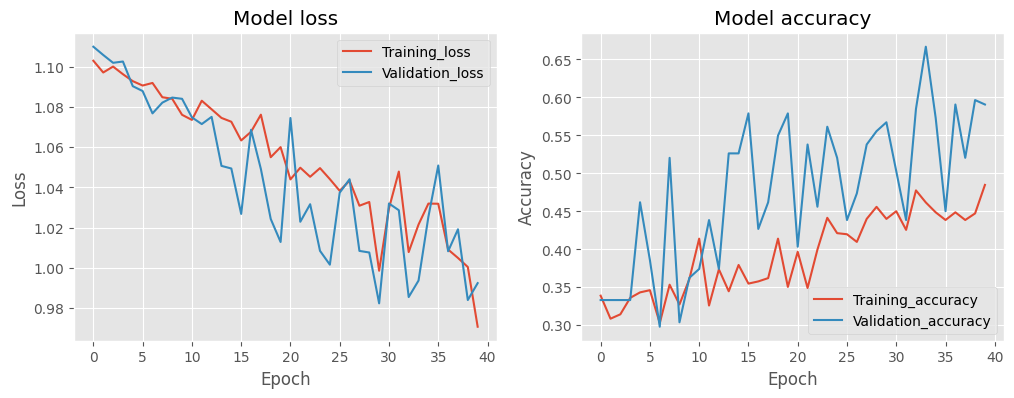

In [29]:
plot_history(h1, 40)

**Predicting with the model**

1/1 [==============================] - 0s 183ms/step


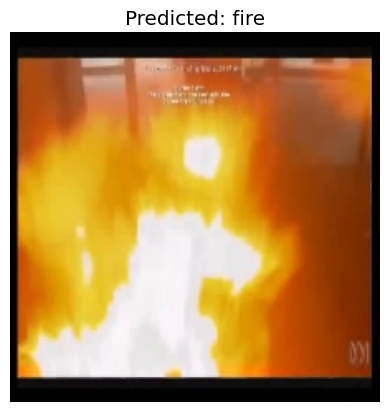

default - Score: 0.02
fire - Score: 0.84
smoke - Score: 0.14
1/1 [==============================] - 0s 18ms/step


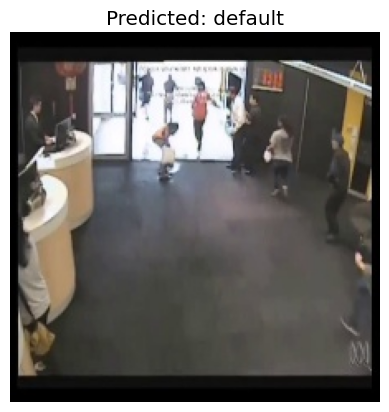

default - Score: 0.36
fire - Score: 0.32
smoke - Score: 0.31


In [51]:
custom = load_model('/content/model/custom.h5')

images = ['/content/data/img_data/test/fire/img_259.jpg' ,
          '/content/data/img_data/test/default/img_210.jpg']

for img_path in images:
  predict_class(img_path,'custom', custom)

# **ResNet50 model**

In [35]:
h2, resnet = create_model('resnet50')

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/40
22/22 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 0.5729
Epoch 1: val_loss improved from inf to 0.89671, saving model to /content/model/resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 34s 1s/step - loss: 0.9329 - accuracy: 0.5729 - val_loss: 0.8967 - val_accuracy: 0.5906
Epoch 2/40
22/22 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.8139
Epoch 2: val_loss improved from 0.89671 to 0.89415, saving model to /content/model/resnet50.h5
22/22 [==============================] - 16s 751ms/step - loss: 0.4883 - accuracy: 0.8139 - val_loss: 0.8941 - val_accuracy: 0.5789
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.8658
Epoch 3: val_loss did not improve from 0.89415
22/22 [==============================] - 17s 796ms/step - loss: 0.3545 - accuracy: 0.8658 - val_loss: 0.9496 - val_accuracy: 0.6023
Epoch 4/40
22/22 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.9048
Epoch 4: val_loss did not improve from 0.89415
22/22 [==============================] - 18s 818ms/step - loss: 0.2924 - accuracy: 0.9048 - val_loss: 1.2100 - val_accuracy: 0.4854
Epoc

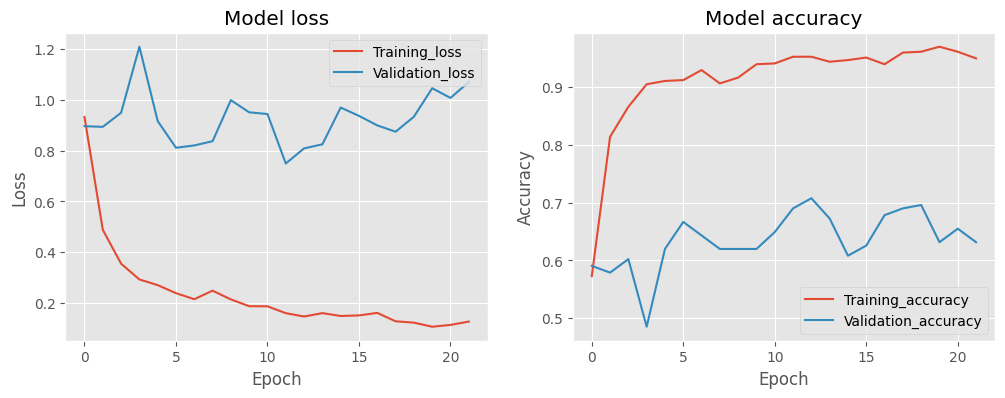

In [37]:
plot_history(h2, 40)

1/1 [==============================] - 1s 855ms/step


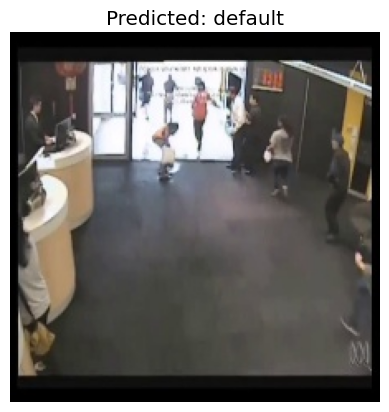

default - Score: 0.65
fire - Score: 0.05
smoke - Score: 0.30
1/1 [==============================] - 0s 29ms/step


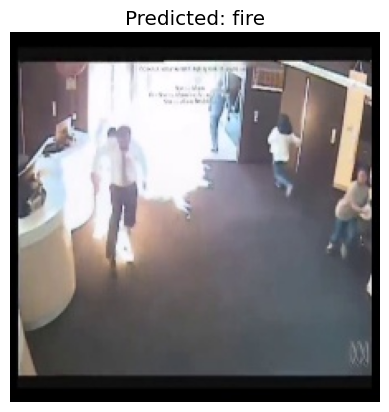

default - Score: 0.05
fire - Score: 0.60
smoke - Score: 0.35


In [49]:
resnet50 = load_model('/content/model/resnet50.h5')

images = ['/content/data/img_data/test/default/img_210.jpg',
          '/content/data/img_data/test/fire/img_213.jpg',]

for img_path in images:
  predict_class(img_path,'resnet50', resnet50)

# **VGG16 model**

In [39]:
h3, vgg16 = create_model('vgg16')

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/40
22/22 [==============================] - ETA: 0s - loss: 2.5143 - accuracy: 0.5036
Epoch 1: val_loss improved from inf to 1.91849, saving model to /content/model/vgg16.h5
22/22 [==============================] - 24s 782ms/step - loss: 2.5143 - accuracy: 0.5036 - val_loss: 1.9185 - val_accuracy: 0.3450


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
22/22 [==============================] - ETA: 0s - loss: 1.0153 - accuracy: 0.7114
Epoch 2: val_loss improved from 1.91849 to 1.30576, saving model to /content/model/vgg16.h5
22/22 [==============================] - 13s 597ms/step - loss: 1.0153 - accuracy: 0.7114 - val_loss: 1.3058 - val_accuracy: 0.4327
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.7864
Epoch 3: val_loss improved from 1.30576 to 1.18193, saving model to /content/model/vgg16.h5
22/22 [==============================] - 13s 609ms/step - loss: 0.6122 - accuracy: 0.7864 - val_loss: 1.1819 - val_accuracy: 0.5029
Epoch 4/40
22/22 [==============================] - ETA: 0s - loss: 0.4976 - accuracy: 0.7980
Epoch 4: val_loss did not improve from 1.18193
22/22 [==============================] - 13s 594ms/step - loss: 0.4976 - accuracy: 0.7980 - val_loss: 1.3191 - val_accuracy: 0.4561
Epoch 5/40
22/22 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.82

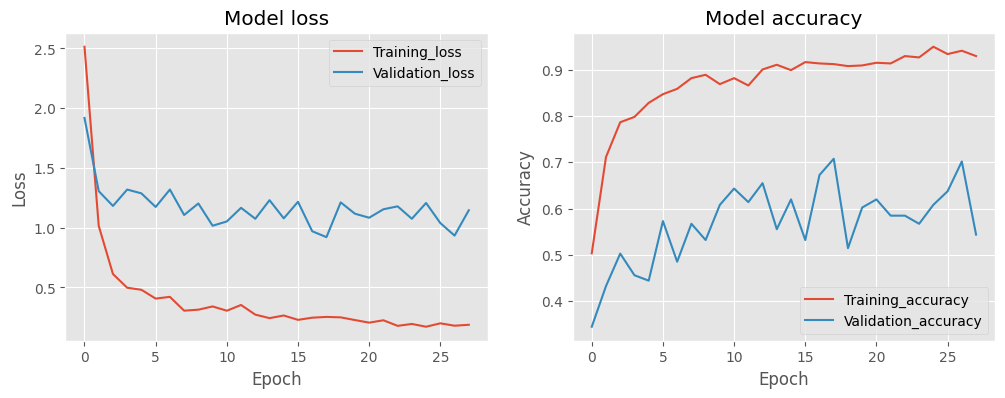

In [40]:
plot_history(h3, 40)

1/1 [==============================] - 0s 132ms/step


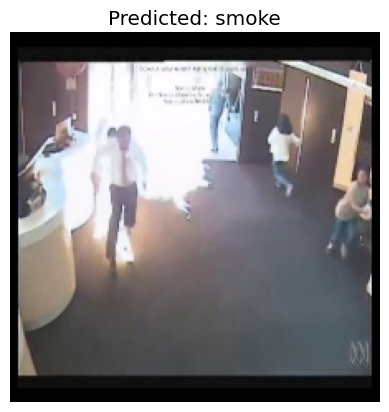

default - Score: 0.04
fire - Score: 0.02
smoke - Score: 0.94
1/1 [==============================] - 0s 19ms/step


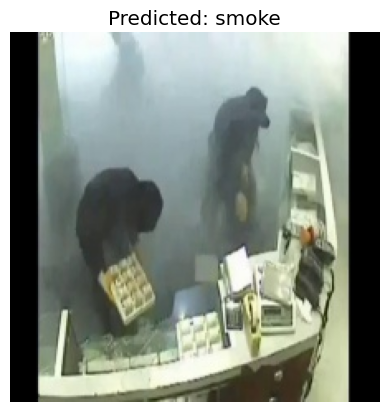

default - Score: 0.46
fire - Score: 0.02
smoke - Score: 0.52


In [50]:
vgg16 = load_model('/content/model/vgg16.h5')

images = ['/content/data/img_data/test/fire/img_213.jpg',
          '/content/data/img_data/test/smoke/img_332.jpg',]

for img_path in images:
  predict_class(img_path,'vgg16', vgg16)